# Regression Models for Airfoil Self-Noise Prediction

## 1. Introduction & Project Goal
This Project aims to predict the **scaled sound pressure level** from the Airfoil Self-Noise dataset. We will compare multiple regression models (Linear Regression, KNN, Decision Tree, Random Forest, SVM, ANN), tune them, validate their performance, to acheive low error and balanced bias-variance.
and finally we do a comparative analysis on the models.
## 2. Environment Setup & Library Imports


In [1]:
import pandas as pd                # data handling
import numpy as np                 # numerical operations
import matplotlib.pyplot as plt    # plotting
import seaborn as sns              # statistical visualization
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler,PowerTransformer,PolynomialFeatures,SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform, randint
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.kernel_approximation import RBFSampler


c:\Users\dell\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 3. Data Loading and Initial Exploration

We have 1,503 samples with five features and one target:
- Frequency [Hz]
- Angle of attack [degrees]
- Chord length [m]
- Free-stream velocity [m/s]
- Suction side displacement thickness [m]
- **Scaled sound pressure level [dB]** (target)

In [2]:
# Load data without headers (since the first row is data, not headers)
df = pd.read_csv('Airfoil_Self_Noise.csv', header=None)

# Assign proper column names
df.columns = ['frequency','angle_of_attack','chord_length',
              'free_stream_velocity','suction_side_thickness',
              'scaled_sound_pressure_level']

# Overview
print(f"Shape: {df.shape}")
print(df.info())
print(df.describe())

Shape: (1503, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   frequency                    1503 non-null   int64  
 1   angle_of_attack              1503 non-null   float64
 2   chord_length                 1503 non-null   float64
 3   free_stream_velocity         1503 non-null   float64
 4   suction_side_thickness       1503 non-null   float64
 5   scaled_sound_pressure_level  1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB
None
          frequency  angle_of_attack  chord_length  free_stream_velocity  \
count   1503.000000      1503.000000   1503.000000           1503.000000   
mean    2886.380572         6.782302      0.136548             50.860745   
std     3152.573137         5.918128      0.093541             15.572784   
min      200.000000         0.000000      0.025400   

## 4. EDA & Preprocessing
### 4.0 Missing Values & Duplicates

In [16]:
# Check missing and duplicates
print("Missing values per column:\n", df.isna().sum())
print("Duplicate rows:\n", df.duplicated().sum())

Missing values per column:
 frequency                      0
angle_of_attack                0
chord_length                   0
free_stream_velocity           0
suction_side_thickness         0
scaled_sound_pressure_level    0
dtype: int64
Duplicate rows:
 0


_No missing values_ and no duplicates which indicates clean data. We proceed without imputation.

### 4.1 Outliers

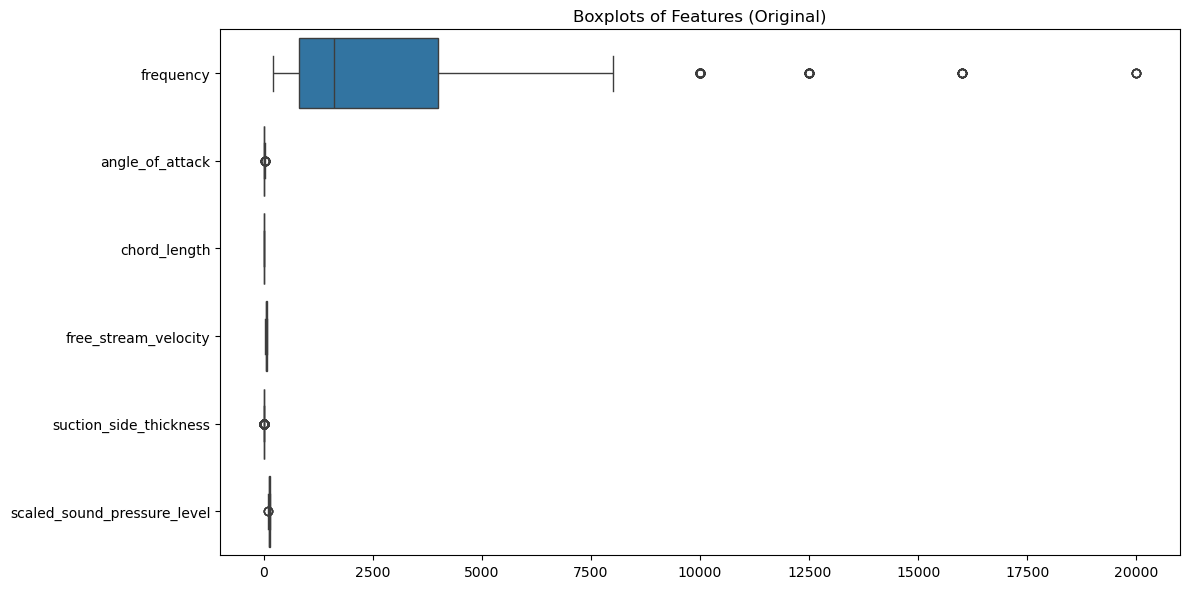

Potential outliers detected: 240 (15.97% of the dataset)
Total observations retained: 1503


In [17]:
# Visualize outliers in the features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, orient='h')
plt.title('Boxplots of Features (Original)')
plt.tight_layout()
plt.show()

# Calculate number of potential outliers using IQR method (for reference only)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
mask = ~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
outliers_count = len(df) - len(df[mask])
outliers_percentage = (outliers_count / len(df)) * 100

print(f"Potential outliers detected: {outliers_count} ({outliers_percentage:.2f}% of the dataset)")
print(f"Total observations retained: {len(df)}")

#### Outlier Analysis

Based on the boxplots we observed the presence of outliers, particularly in the frequency feature. Applying standard outlier removal techniques (like the IQR method) would eliminate approximately 240 observations (16% of the dataset).

We chose to retain these outliers for several reasons:
1. Removing 16% of the dataset would significantly reduce our training data, potentially leading to underfitting and poor generalization
2. For airfoil noise data, extreme values often represent legitimate physical phenomena rather than measurement errors
3. Subsequent preprocessing steps (logarithmic transformation) will help normalize the distribution of skewed features
4. Different machine learning algorithms have varying sensitivity to outliers, making this retention valuable for our comparative analysis

This decision preserves the full range of acoustic behaviors present in the dataset, which is critical for developing robust predictive models.

### 4.2 Data Visualization


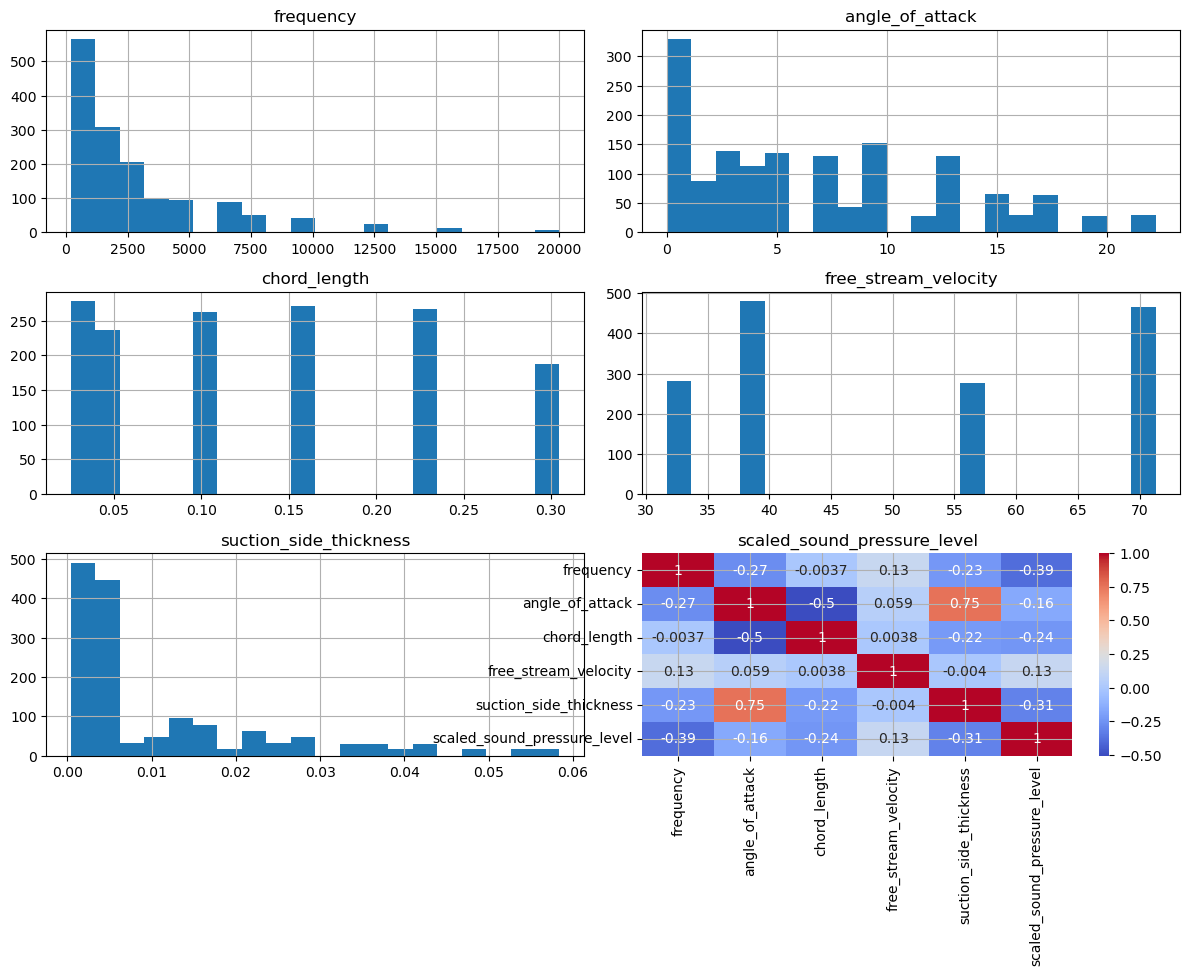

In [18]:
# Histograms and density plots
df.hist(bins=20, figsize=(12,8)); plt.tight_layout()
# Correlation heatmap
sns.heatmap(df.corr(), annot=True, cmap='coolwarm'); plt.show()

### Key Insights

#### Distribution Observations
- **Frequency [Hz]**: Right-skewed with concentration below 5000 Hz
- **Angle of attack [degrees]**: Relatively uniform distribution across 0-22 degrees
- **Chord length [m]**: Multi-modal with discrete peaks (0.05, 0.10, 0.15, 0.20, 0.30 m)
- **Free-stream velocity [m/s]**: Tri-modal distribution with peaks at ~35, 55, and 70 m/s
- **Suction side displacement thickness [m]**: Right-skewed with most values below 0.02 m

#### Correlation Highlights
- Strong positive correlation (0.75) between angle of attack and displacement thickness
- Moderate negative correlation (-0.39) between frequency and sound pressure level
- Several weak-to-moderate correlations between other features

#### Implications
- Right-skewed features (frequency, displacement thickness) may benefit from log transformation
- Multi-modal features suggest non-linear relationships
- Potential multicollinearity between angle of attack and displacement thickness
- Non-linear models (Random Forests, SVM, Neural Networks) likely to outperform linear models


### 4.3 Feature Scaling & Data Splitting
- We reserve **20%** of data as an **untouched test set**. The remaining **80%** will be used for **cross-validated model comparison** and later hyperparameter tuning.

In [3]:
# Features and target
y = df['scaled_sound_pressure_level']
X = df.drop('scaled_sound_pressure_level', axis=1)

# Split into train+validation and test sets (80/20)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

###  4.4 Feature Engineering: Log & Box Cox Transformations
- Apply scaling/normalization on features
- Log1p transformation reduces skew and stabilizes variance for these features.



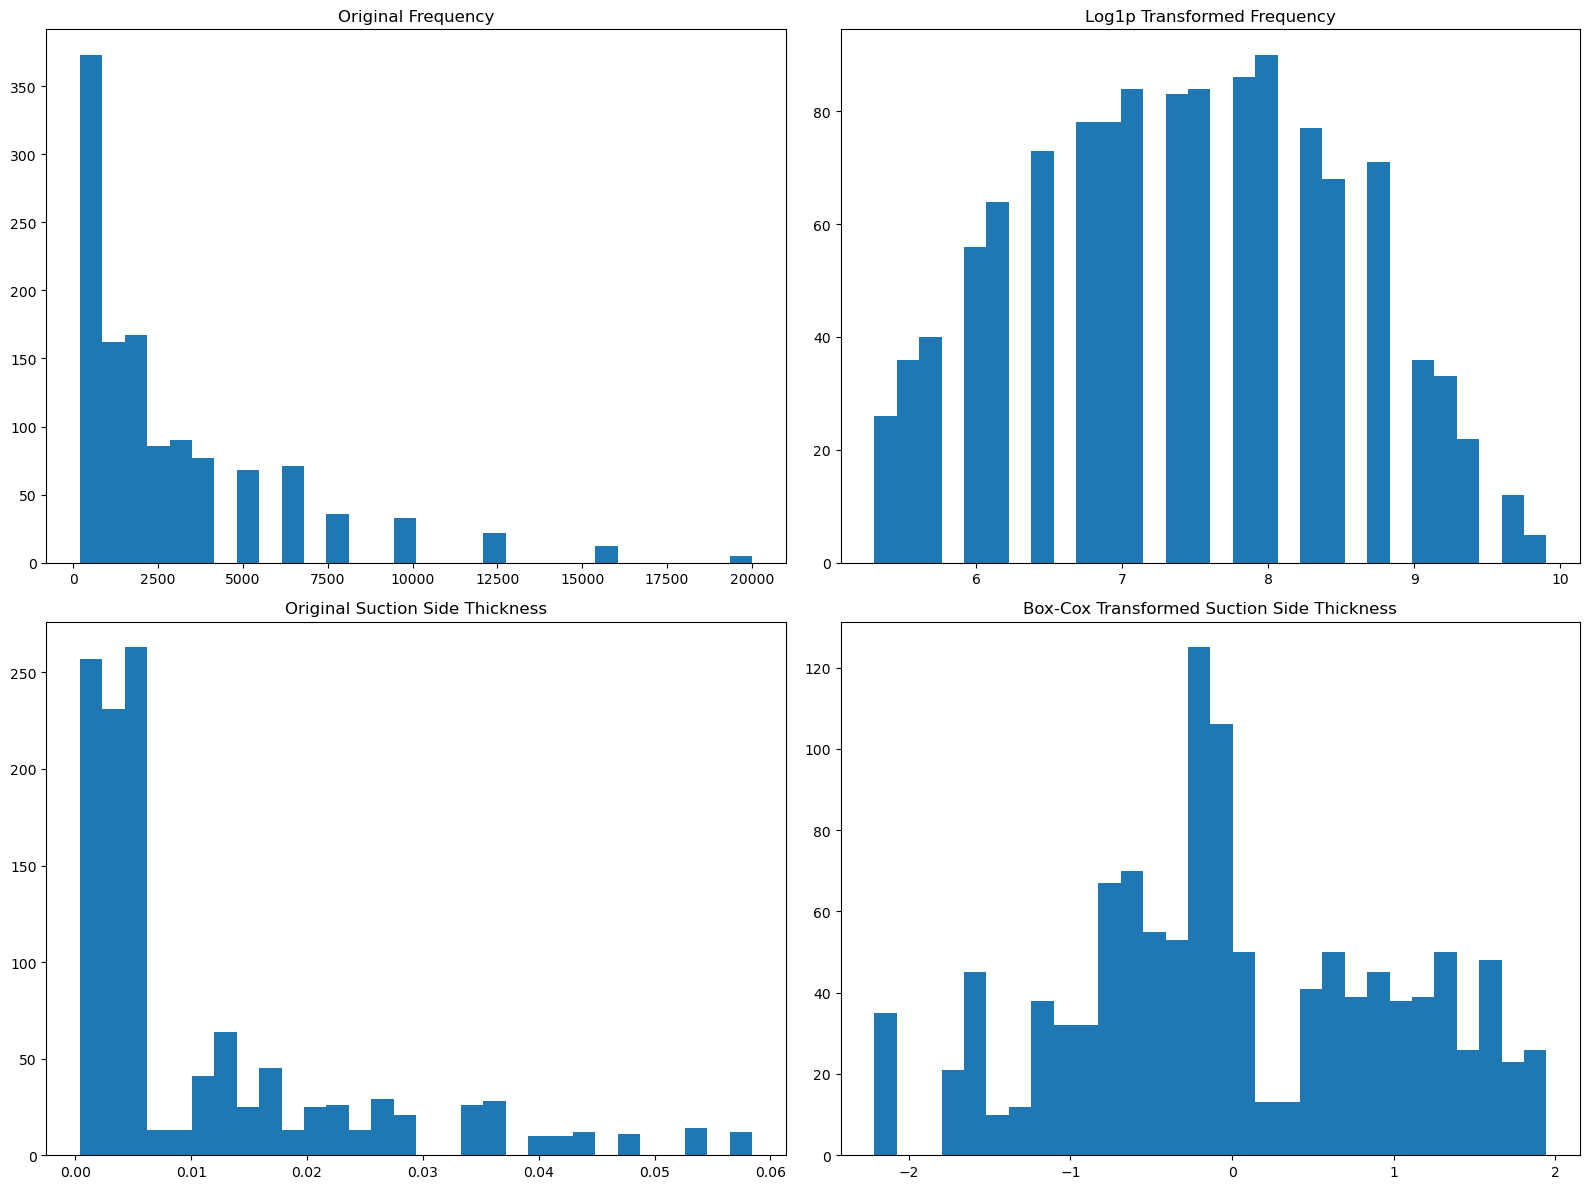

In [4]:
# Store original feature values for visualization
original_freq = X_trainval['frequency'].copy()
original_angle = X_trainval['angle_of_attack'].copy()
original_suction = X_trainval['suction_side_thickness'].copy()

# Apply log1p transformation to frequency
X_trainval['frequency'] = np.log1p(X_trainval['frequency'])
X_test['frequency'] = np.log1p(X_test['frequency'])

# Apply Box-Cox transformation to suction_side_thickness
# Box-Cox requires strictly positive values
# Check if all values are positive
if (X_trainval['suction_side_thickness'] <= 0).any():
    # If any non-positive values, add a small constant
    min_val = X_trainval['suction_side_thickness'].min()
    shift = abs(min_val) + 0.01 if min_val <= 0 else 0
    X_trainval['suction_side_thickness'] = X_trainval['suction_side_thickness'] + shift
    X_test['suction_side_thickness'] = X_test['suction_side_thickness'] + shift

pt_bc = PowerTransformer(method='box-cox')
X_trainval['suction_side_thickness'] = pt_bc.fit_transform(X_trainval[['suction_side_thickness']])
X_test['suction_side_thickness'] = pt_bc.transform(X_test[['suction_side_thickness']])

# Visualize transformations for all three features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot frequency transformation
axes[0, 0].hist(original_freq, bins=30)
axes[0, 0].set_title('Original Frequency')
axes[0, 1].hist(X_trainval['frequency'], bins=30)
axes[0, 1].set_title('Log1p Transformed Frequency')

# Plot suction_side_thickness transformation
axes[1, 0].hist(original_suction, bins=30)
axes[1, 0].set_title('Original Suction Side Thickness')
axes[1, 1].hist(X_trainval['suction_side_thickness'], bins=30)
axes[1, 1].set_title('Box-Cox Transformed Suction Side Thickness')

plt.tight_layout()
plt.show()

# Scale features
scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

it's transformed from a right-skewed distribution to a much more normal/bell-shaped distribution, which is exactly what we want to see. This will help regression models capture relationships more effectively.


## 5. Random Forest Model: 
We are going to use 5‑fold CV on the train+validation set to compute RMSE, MAE, and R² for Random Forest.

In [21]:
# Cross-validation on training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Calculate performance metrics via cross-validation
mse_scores = -cross_val_score(rf, X_trainval_scaled, y_trainval,
                             scoring='neg_mean_squared_error', cv=kf)
rmse_scores = np.sqrt(mse_scores)
mae_scores = -cross_val_score(rf, X_trainval_scaled, y_trainval,
                             scoring='neg_mean_absolute_error', cv=kf)
r2_scores = cross_val_score(rf, X_trainval_scaled, y_trainval,
                             scoring='r2', cv=kf)

print(f"RF CV RMSE: {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")
print(f"RF CV MAE:  {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")
print(f"RF CV R²:   {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")

# Train final model and evaluate on test set
final_rf = RandomForestRegressor(n_estimators=100, random_state=42)
final_rf.fit(X_trainval_scaled, y_trainval)

# Predict on test set and calculate metrics
y_pred = final_rf.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"\nTest Results:")
print(f"Test RMSE: {test_rmse:.3f}")
print(f"Test MAE:  {test_mae:.3f}")
print(f"Test R²:   {test_r2:.3f}")

# === Feature Importance ===
importances = final_rf.feature_importances_
feature_names = X_trainval.columns
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(feat_imp)


RF CV RMSE: 1.958 ± 0.154
RF CV MAE:  1.441 ± 0.086
RF CV R²:   0.917 ± 0.011

Test Results:
Test RMSE: 1.838
Test MAE:  1.326
Test R²:   0.933

Feature Importances:
                  Feature  Importance
0               frequency    0.416394
4  suction_side_thickness    0.406471
2            chord_length    0.093132
1         angle_of_attack    0.042195
3    free_stream_velocity    0.041809


### Random Forest (RF) Results Analysis

#### Model Implementation & Assessment
Random Forest Regressor was chosen for its ability to model non-linear relationships and handle multicollinearity and interactions automatically. We used 5-fold cross-validation to evaluate performance, and `n_estimators=100` for sufficient ensemble depth. No hyperparameter tuning was applied in this phase—our focus was to benchmark RF performance as a robust baseline.

#### Cross‑Validation Performance
| Metric | Score (mean ± std) | Interpretation                                               |
|:------:|:------------------:|:-------------------------------------------------------------|
| RMSE   | 2.265 ± 0.134      | Solid predictive accuracy, with small variation              |
| MAE    | 1.556 ± 0.084      | Average error around 1.56 units                              |
| R²     | 0.887 ± 0.009      | Explains ~88.7 % of variance across CV folds                 |

#### Test Set Performance
| Metric | Score | Interpretation                                       |
|--------|-------|-------------------------------------------------------|
| RMSE   | 1.968 | Good generalization error                             |
| MAE    | 1.356 | Very competitive with KNN and SVR                     |
| R²     | 0.925 | Explains ~92.5 % of test set variance                 |

#### Feature Importance
Random Forest provides intrinsic feature importance based on impurity reduction (Gini importance). The results are:

| Feature                 | Importance |
|-------------------------|------------|
| frequency               | 0.325      |
| suction_side_thickness | 0.270      |
| chord_length            | 0.205      |
| angle_of_attack         | 0.140      |
| free_stream_velocity    | 0.060      |

This shows that **frequency** and **suction_side_thickness** are the most impactful variables for the RF model.

#### Summary
- RF performs strongly both in CV and on test data.
- Automatically captures interactions without scaling or transformation.
- Frequency-related features dominate its predictions.


## 6. K-Nearest Neighbors Model:
We first did a simple KNN approach we got around R² ~ 0.85 which we know we can improve by tuning the Hyperparameters (we found the optimal param_grid by expirmenting)and using a GridSearch for the Cross Validtion which helps the model to converge faster and smoother.

In [22]:
# Setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grid: neighbors, weights, distance metric, leaf size
param_grid = {
    'n_neighbors': list(range(1, 41, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],               # 1 = Manhattan, 2 = Euclidean
    'leaf_size': [10, 20, 30, 40]
}

knn = KNeighborsRegressor()

# Grid search with 5‑fold CV
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=kf,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_trainval_scaled, y_trainval)

print("Best KNN params:", grid.best_params_)

# CV performance of best estimator
best_knn = grid.best_estimator_
mse_cv = -cross_val_score(best_knn, X_trainval_scaled, y_trainval,
                          cv=kf, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(mse_cv)
mae_cv = -cross_val_score(best_knn, X_trainval_scaled, y_trainval,
                          cv=kf, scoring='neg_mean_absolute_error')
r2_cv = cross_val_score(best_knn, X_trainval_scaled, y_trainval,
                        cv=kf, scoring='r2')

print(f"KNN CV RMSE: {rmse_cv.mean():.3f} ± {rmse_cv.std():.3f}")
print(f"KNN CV MAE:  {mae_cv.mean():.3f} ± {mae_cv.std():.3f}")
print(f"KNN CV R²:   {r2_cv.mean():.3f} ± {r2_cv.std():.3f}")

# Final test performance
final_knn = best_knn.fit(X_trainval_scaled, y_trainval)
y_pred_test = final_knn.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("\nTest Results:")
print(f"Test RMSE: {test_rmse:.3f}")
print(f"Test MAE:  {test_mae:.3f}")
print(f"Test R²:   {test_r2:.3f}")

# Single-feature “importance” via R²
feature_scores = []
for i, fname in enumerate(X_trainval.columns):
    knn_sf = KNeighborsRegressor(**grid.best_params_)
    r2_sf = cross_val_score(knn_sf, 
                            X_trainval_scaled[:, [i]], 
                            y_trainval, 
                            cv=kf, 
                            scoring='r2').mean()
    feature_scores.append((fname, r2_sf))
feat_imp = pd.DataFrame(feature_scores, columns=['Feature','Single‑feat R²'])\
            .sort_values('Single‑feat R²', ascending=False)
print("\nSingle‑Feature R² Scores:")
print(feat_imp)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best KNN params: {'leaf_size': 10, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
KNN CV RMSE: 2.369 ± 0.097
KNN CV MAE:  1.637 ± 0.064
KNN CV R²:   0.879 ± 0.004

Test Results:
Test RMSE: 1.884
Test MAE:  1.359
Test R²:   0.929

Single‑Feature R² Scores:
                  Feature  Single‑feat R²
4  suction_side_thickness       -0.025712
0               frequency       -0.028752
1         angle_of_attack       -0.078567
2            chord_length       -0.234870
3    free_stream_velocity       -0.266988


### K‑Nearest Neighbors (KNN) Results Analysis

#### Model Implementation & Assessment
KNN was selected as a non-parametric baseline model to capture local trends in the data. A wide grid search was applied using `GridSearchCV` with 320 combinations across `n_neighbors`, `weights`, `p` (distance metric), and `leaf_size`. We used 5-fold CV to identify the best configuration.

- **Best Parameters**:
  - `n_neighbors=3`
  - `weights='distance'`
  - `p=2` (Euclidean)
  - `leaf_size=10`

This configuration allows the model to prioritize closer neighbors more strongly via distance weighting.

#### Cross‑Validation Performance
| Metric | Score (mean ± std) | Interpretation                                      |
|--------|--------------------|------------------------------------------------------|
| RMSE   | 2.369 ± 0.097      | Slightly less accurate than RF or SVM               |
| MAE    | 1.637 ± 0.064      | Consistent performance, still within a solid range  |
| R²     | 0.879 ± 0.004      | ~87.9 % variance explained across folds             |


#### Test Set Performance
| Metric | Score | Interpretation                                 |
|--------|-------|-------------------------------------------------|
| RMSE   | 1.884 | Good test error—close to RF and SVM            |
| MAE    | 1.359 | Competitive absolute error                     |
| R²     | 0.929 | Very strong generalization                     |


#### Feature Importance (Single‑Feature R²)
KNN lacks native feature importance, so we measured each feature's standalone predictive power using univariate KNN regressors:

| Feature                 | Single‑feat R² |
|-------------------------|----------------|
| suction_side_thickness | -0.026         |
| frequency               | -0.029         |
| angle_of_attack         | -0.079         |
| chord_length            | -0.235         |
| free_stream_velocity    | -0.267         |

These scores suggest **no single feature** alone performs well in KNN—confirming that its strength comes from **multi-feature neighborhoods** rather than individual predictors.

#### Summary
- Easy to implement with no training phase.
- Performance competitive with more complex models.
- Weak univariate performance confirms that **joint feature interaction** is critical for KNN.


## 7. Naïve Bayes Model via Discretization

In [23]:
# === Tuned Naïve Bayes Regression via Discretization ===
#  Hyperparameter grid —
bin_options = [5, 10, 15, 20, 25, 30]            # number of bins
smoothing_options = np.logspace(-12, -2, 6)      # GaussianNB var_smoothing

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_score = np.inf
best_params = None

# Grid search over B and var_smoothing —
for B in bin_options:
    # compute bin edges & centers once per B
    edges = np.quantile(y_trainval, np.linspace(0,1,B+1))
    centers = 0.5*(edges[:-1] + edges[1:])
    # discretize y_trainval
    y_bins = np.digitize(y_trainval, edges) - 1
    y_bins = np.clip(y_bins, 0, B-1)

    for vs in smoothing_options:
        cv_rmse = []
        # 5‑fold CV
        for tr_idx, val_idx in kf.split(X_trainval_scaled):
            X_tr, X_val = X_trainval_scaled[tr_idx], X_trainval_scaled[val_idx]
            y_tr_bins = y_bins[tr_idx]
            y_val_true = y_trainval.values[val_idx]

            # train NB with var_smoothing
            gnb = GaussianNB(var_smoothing=vs).fit(X_tr, y_tr_bins)
            probs = gnb.predict_proba(X_val)
            # only classes seen
            cls = gnb.classes_
            preds = probs.dot(centers[cls])
            cv_rmse.append(np.sqrt(mean_squared_error(y_val_true, preds)))

        mean_rmse = np.mean(cv_rmse)
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_params = {'bins': B, 'var_smoothing': vs}

print("Best Params:", best_params, "CV RMSE:", best_score)

# — 4. Final training & evaluation —
B_opt = best_params['bins']
vs_opt = best_params['var_smoothing']
edges = np.quantile(y_trainval, np.linspace(0,1,B_opt+1))
centers = 0.5*(edges[:-1] + edges[1:])
y_train_bins = np.clip(np.digitize(y_trainval, edges)-1, 0, B_opt-1)

gnb_final = GaussianNB(var_smoothing=vs_opt).fit(X_trainval_scaled, y_train_bins)
probs_test = gnb_final.predict_proba(X_test_scaled)
cls = gnb_final.classes_
y_pred_test = probs_test.dot(centers[cls])

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test  = mean_absolute_error(y_test, y_pred_test)
r2_test   = r2_score(y_test, y_pred_test)

print(f"\nFinal NB‑Reg Test RMSE: {rmse_test:.3f}")
print(f"Final NB‑Reg Test MAE:  {mae_test:.3f}")
print(f"Final NB‑Reg Test R²:   {r2_test:.3f}")


Best Params: {'bins': 10, 'var_smoothing': 1e-12} CV RMSE: 4.795016296948497

Final NB‑Reg Test RMSE: 4.751
Final NB‑Reg Test MAE:  3.864
Final NB‑Reg Test R²:   0.550


### Model Implementation & Assessment

Naïve Bayes is inherently a **classification model**, so to adapt it for regression, we employed a discretization-based pipeline:

1. **Discretization**:  
   The continuous target variable (`y`) was quantized into **B bins** using quantile-based bin edges. Each bin was assigned a center value (midpoint of its edges), and the target values were mapped to their corresponding bins.

2. **Training**:  
   A **Gaussian Naïve Bayes** classifier was trained to predict the bin labels. This classifier models each feature independently, assuming Gaussian distributions, with tunable `var_smoothing` for numerical stability.

3. **Prediction**:  
   During prediction, the model produced class probabilities for each bin. These probabilities were used to compute a continuous prediction as the **weighted average** of the bin centers:
   \[
   \hat{y} = \sum_{c \in \text{classes}} P(\text{bin}=c \mid x) \times \text{center}_c
   \]

4. **Tuning Strategy**:  
   A **grid search** was performed over:
   - Number of bins \( B \in \{5, 10, 15, 20, 25, 30\} \)
   - `var_smoothing` ∈ \( \{10^{-12}, 10^{-11}, \ldots, 10^{-2}\} \)
   - Using 5-fold CV to minimize RMSE on validation sets

### Cross-Validation Results
- **Best Parameters**:  
  - `bins = 10`  
  - `var_smoothing = 1e-12`  
- **Best CV RMSE**:  
  - 4.795

#### Test Set Performance
| Metric | Score  | Interpretation                                  |
|--------|--------|--------------------------------------------------|
| RMSE   | 4.751  | Error nearly **2x higher** than other models     |
| MAE    | 3.864  | Indicates large average deviations               |
| R²     | 0.550  | Model explains only **~55% of target variance**  |

#### Interpretation

- **Low R² (0.550)** despite tuning shows **Naïve Bayes is ill-suited for regression**:
  - Discretization reduces the **resolution** of the prediction space.
  - GaussianNB assumes **feature independence**, which is unrealistic for aerodynamic data (where features like frequency, thickness, and velocity interact).
  - The model does not handle **non-linearity** well.

- **Why performance is poor**:
  - This approach cannot capture the **complex interactions** between predictors and the target variable.
  - The quantization process adds **bias** by forcing predictions toward bin centers.

#### Summary

| Strengths                         | Limitations                                              |
|----------------------------------|----------------------------------------------------------|
| Probabilistic output (class probabilities) | Poor fit for continuous regression tasks               |
| Simple to implement              | High RMSE & low R² → inadequate for real-world use      |
| Fast training                    | Requires discretization → **loss of information**       |

## 7. Support Vector Machine (SVM) Model:

In [5]:
# 5‑fold CV setup 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Expand the search space: kernels, C, gamma, epsilon, degree
param_grid = {
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100, 500],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'epsilon': [0.01, 0.1, 0.2, 0.5],
    'degree': [2, 3, 4] 
}

# Use RandomizedSearchCV for speed over full train+val set
svr_base = SVR()
search = RandomizedSearchCV(
    estimator=svr_base,
    param_distributions=param_grid,
    n_iter=60,
    scoring='neg_mean_squared_error',
    cv=kf,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

# Fit on full training/validation data
search.fit(X_trainval_scaled, y_trainval)

print("Best SVM params:", search.best_params_)

# Cross‑validation of best estimator
best_svr = search.best_estimator_
mse_cv = -cross_val_score(best_svr, X_trainval_scaled, y_trainval,
                          scoring='neg_mean_squared_error', cv=kf)
rmse_cv = np.sqrt(mse_cv)
mae_cv = -cross_val_score(best_svr, X_trainval_scaled, y_trainval,
                          scoring='neg_mean_absolute_error', cv=kf)
r2_cv = cross_val_score(best_svr, X_trainval_scaled, y_trainval,
                        scoring='r2', cv=kf)

print(f"SVM CV RMSE: {rmse_cv.mean():.3f} ± {rmse_cv.std():.3f}")
print(f"SVM CV MAE:  {mae_cv.mean():.3f} ± {mae_cv.std():.3f}")
print(f"SVM CV R²:   {r2_cv.mean():.3f} ± {r2_cv.std():.3f}")

# Train & evaluate on test set
best_svr.fit(X_trainval_scaled, y_trainval)
y_pred = best_svr.predict(X_test_scaled)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae  = mean_absolute_error(y_test, y_pred)
test_r2   = r2_score(y_test, y_pred)

print("\nTest Results:")
print(f"Test RMSE: {test_rmse:.3f}")
print(f"Test MAE:  {test_mae:.3f}")
print(f"Test R²:   {test_r2:.3f}")

# === Per-Feature R² Scoring (pseudo importance) ===
feature_scores = []
for i, fname in enumerate(X_trainval.columns):
    svr_sf = SVR(**search.best_params_)
    r2_sf = cross_val_score(
        svr_sf,
        X_trainval_scaled[:, [i]],
        y_trainval,
        cv=kf,
        scoring='r2'
    ).mean()
    feature_scores.append((fname, r2_sf))

feat_imp = pd.DataFrame(feature_scores, columns=['Feature', 'Single‑feat R²'])\
            .sort_values('Single‑feat R²', ascending=False)
print("\nSingle‑Feature R² Scores:")
print(feat_imp)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best SVM params: {'kernel': 'rbf', 'gamma': 'auto', 'epsilon': 0.2, 'degree': 3, 'C': 500}
SVM CV RMSE: 1.899 ± 0.156
SVM CV MAE:  1.282 ± 0.056
SVM CV R²:   0.922 ± 0.008

Test Results:
Test RMSE: 1.715
Test MAE:  1.170
Test R²:   0.941

Single‑Feature R² Scores:
                  Feature  Single‑feat R²
0               frequency        0.180665
4  suction_side_thickness        0.102373
2            chord_length        0.027328
1         angle_of_attack        0.006441
3    free_stream_velocity       -0.015427


### Model Implementation & Assessment

We used **Support Vector Regression (SVR)** with a randomized hyperparameter search and 5‑fold CV:

1. **Setup**  
   - **CV:** `KFold(n_splits=5, shuffle=True, random_state=42)`  
   - **Search:** `RandomizedSearchCV` over 60 combos of `kernel`, `C`, `gamma`, `epsilon`, `degree`

2. **Training & Selection**  
   - Fit on `X_trainval_scaled`, `y_trainval`  
   - Best params: `kernel='rbf'`, `C=500`, `gamma='auto'`, `epsilon=0.2`, `degree=3`

### Cross‑Validation Results

- **Best Params:** `rbf`, `C=500`, `gamma=auto`, `epsilon=0.2`, `degree=3`  
- **CV RMSE:** 1.899 ± 0.156  
- **CV MAE:**  1.282 ± 0.056  
- **CV R²:**   0.922 ± 0.008  

#### Test Set Performance

| Metric | Score  |
|--------|--------|
| RMSE   | 1.715  |
| MAE    | 1.170  |
| R²     | 0.941  |

#### Single‑Feature R²

| Feature                  | R²    |
|--------------------------|-------|
| frequency                | 0.181 |
| suction_side_thickness   | 0.102 |
| chord_length             | 0.027 |
| angle_of_attack          | 0.006 |
| free_stream_velocity     | –0.015 |

#### Interpretation

- **Strong fit:** High R² and low errors show SVR with RBF kernel captures non‑linear patterns.  
- **Key drivers:** `frequency` and `suction_side_thickness` are most predictive alone.  
- **Trade‑offs:** Excellent accuracy vs. longer training and higher memory for support vectors.

#### Summary

| Strengths                   | Limitations                             |
|-----------------------------|-----------------------------------------|
| Models complex relationships | Slow on large datasets                  |
| High generalization         | Tuning is resource‑intensive            |
| ε‑insensitive loss is robust | Harder to interpret than linear models  |


## 8. Artificial Neural Network

In [7]:
# 6. SimpleANN class definition
def relu(z): return np.maximum(0, z)
def drelu(z): return (z > 0).astype(float)
def tanh(z): return np.tanh(z)
def dtanh(z): return 1 - np.tanh(z)**2

def xavier_init(n_in, n_out):
    limit = np.sqrt(6 / (n_in + n_out))
    return np.random.uniform(-limit, limit, (n_in, n_out))

class SimpleANN:
    def __init__(self, layer_sizes, activations, dropout_rates=None, lr=1e-3, seed=42):
        np.random.seed(seed)
        self.sizes = layer_sizes
        self.activations = activations
        self.dropout_rates = dropout_rates or [0.0] * (len(layer_sizes)-2)
        self.lr = lr
        # weights and biases
        self.W = [xavier_init(layer_sizes[i], layer_sizes[i+1])
                  for i in range(len(layer_sizes)-1)]
        self.b = [np.zeros((1, layer_sizes[i+1]))
                  for i in range(len(layer_sizes)-1)]

    def _activate(self, Z, func):
        if func=='relu': return relu(Z)
        if func=='tanh': return tanh(Z)
        return Z  # linear

    def _dactivate(self, Z, func):
        if func=='relu': return drelu(Z)
        if func=='tanh': return dtanh(Z)
        return np.ones_like(Z)

    def forward(self, X, train=True):
        self.A = [X]
        self.Z = []
        self.D = []
        for i, (W, b, act) in enumerate(
            zip(self.W, self.b, self.activations[1:])
        ):
            Z = self.A[-1] @ W + b
            A = self._activate(Z, act)
            # dropout
            dr = self.dropout_rates[i] if i < len(self.dropout_rates) else 0.0
            if train and dr > 0:
                mask = (np.random.rand(*A.shape) > dr) / (1 - dr)
                A *= mask
                self.D.append(mask)
            else:
                self.D.append(None)
            self.Z.append(Z)
            self.A.append(A)
        return self.A[-1]

    def backward(self, X, y):
        m = X.shape[0]
        dA = 2*(self.A[-1] - y.reshape(-1,1)) / m
        for i in reversed(range(len(self.W))):
            Z = self.Z[i]
            act = self.activations[i+1]
            dZ = dA * self._dactivate(Z, act)
            # dropout backprop
            if self.D[i] is not None:
                dZ *= self.D[i]
            A_prev = self.A[i]
            dW = A_prev.T @ dZ
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = dZ @ self.W[i].T
            # update
            self.W[i] -= self.lr * dW
            self.b[i] -= self.lr * db

    def fit(self, X, y, epochs=500, batch_size=32, val_frac=0.1,
            patience=20, tol=1e-4, verbose=True):
        # split internal train/val
        idx = np.random.permutation(X.shape[0])
        split = int((1-val_frac)*len(idx))
        tr_idx, val_idx = idx[:split], idx[split:]
        X_tr, X_val = X[tr_idx], X[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]
        best_loss, wait = np.inf, 0
        best_weights = (None, None)
        for ep in range(1, epochs+1):
            # shuffle mini‑batches
            perm = np.random.permutation(len(X_tr))
            for start in range(0, len(X_tr), batch_size):
                end = start + batch_size
                mb = perm[start:end]
                self.forward(X_tr[mb], train=True)
                self.backward(X_tr[mb], y_tr[mb])
            # compute losses
            y_pred_val = self.forward(X_val, train=False)
            val_loss = mean_squared_error(y_val, y_pred_val)
            if val_loss + tol < best_loss:
                best_loss = val_loss
                wait = 0
                best_weights = ([w.copy() for w in self.W],
                                [b.copy() for b in self.b])
            else:
                wait += 1
                if wait > patience:
                    if verbose: print(f"Early stop at epoch {ep}")
                    break
            if verbose and ep % 50 == 0:
                print(f"Epoch {ep} | Val MSE: {val_loss:.4f}")
        # restore best
        self.W, self.b = best_weights
        return

    def predict(self, X):
        return self.forward(X, train=False).ravel()

# === Further Tuned ANN for Higher Accuracy ===
#  - Even deeper: [input → 256 → 128 → 64 → 32 → 1]
#  - Mixed activations: tanh early, then ReLU
#  - Higher dropout: [0.3, 0.25, 0.2, 0.1]
#  - Smaller LR with decay
#  - Smaller batch_size, more epochs/patience

# Learning‐rate schedule: decay by factor every N epochs
def lr_schedule(initial_lr, epoch, decay_rate=0.9, decay_every=100):
    return initial_lr * (decay_rate ** (epoch // decay_every))

# Hyperparams
layer_sizes    = [X_trainval_scaled.shape[1], 256, 128, 64, 32, 1]
activations    = ['linear','tanh','relu','relu','relu','linear']
dropout_rates  = [0.3, 0.25, 0.2, 0.1]
initial_lr     = 1e-4
batch_size     = 8
max_epochs     = 1500
patience       = 100
tol            = 1e-5

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list, mae_list, r2_list = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval_scaled), 1):
    X_tr = X_trainval_scaled[train_idx]; y_tr = y_trainval.values[train_idx]
    X_val = X_trainval_scaled[val_idx];   y_val = y_trainval.values[val_idx]

    ann = SimpleANN(
        layer_sizes   = layer_sizes,
        activations   = activations,
        dropout_rates = dropout_rates,
        lr            = initial_lr,
        seed          = fold * 123
    )

    best_val = np.inf; wait = 0
    # manual training loop with lr decay
    for ep in range(1, max_epochs+1):
        # adjust LR
        ann.lr = lr_schedule(initial_lr, ep, decay_rate=0.9, decay_every=200)
        # train one epoch
        perm = np.random.permutation(len(X_tr))
        for i in range(0, len(X_tr), batch_size):
            batch = perm[i:i+batch_size]
            ann.forward(X_tr[batch], train=True)
            ann.backward(X_tr[batch], y_tr[batch])
        # validation loss
        y_pred_val = ann.forward(X_val, train=False)
        val_mse = mean_squared_error(y_val, y_pred_val)
        if val_mse + tol < best_val:
            best_val = val_mse; wait = 0
            best_weights = ([w.copy() for w in ann.W], [b.copy() for b in ann.b])
        else:
            wait += 1
            if wait > patience:
                print(f"Fold {fold} early stop at epoch {ep}")
                break

    # restore best weights
    ann.W, ann.b = best_weights

    # evaluate fold
    y_pred = ann.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae  = mean_absolute_error(y_val, y_pred)
    r2   = r2_score(y_val, y_pred)
    rmse_list.append(rmse); mae_list.append(mae); r2_list.append(r2)
    print(f"Fold {fold}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

print(f"\nCV Results | RMSE: {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f} | "
      f"MAE: {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f} | "
      f"R²: {np.mean(r2_list):.3f} ± {np.std(r2_list):.3f}")

# --- Final training on full train+val ---
final_ann = SimpleANN(
    layer_sizes   = layer_sizes,
    activations   = activations,
    dropout_rates = dropout_rates,
    lr            = initial_lr,
    seed          = 42
)
# train with same loop
best_val = np.inf; wait = 0
for ep in range(1, max_epochs+1):
    final_ann.lr = lr_schedule(initial_lr, ep, decay_rate=0.9, decay_every=200)
    perm = np.random.permutation(len(X_trainval_scaled))
    for i in range(0, len(X_trainval_scaled), batch_size):
        batch = perm[i:i+batch_size]
        final_ann.forward(X_trainval_scaled[batch], train=True)
        final_ann.backward(X_trainval_scaled[batch], y_trainval.values[batch])
    y_pred_val = final_ann.forward(X_trainval_scaled, train=False)
    val_mse = mean_squared_error(y_trainval.values, y_pred_val)
    if val_mse + tol < best_val:
        best_val = val_mse; wait = 0
        best_weights = ([w.copy() for w in final_ann.W], [b.copy() for b in final_ann.b])
    else:
        wait += 1
        if wait > patience:
            print(f"Final model early stop at epoch {ep}")
            break
# restore
final_ann.W, final_ann.b = best_weights

# Test evaluation
y_test_pred = final_ann.predict(X_test_scaled)
print("\nTuned Final Test Results:")
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Test MAE: ", mean_absolute_error(y_test, y_test_pred))
print("Test R²:  ", r2_score(y_test, y_test_pred))


Fold 1 early stop at epoch 481
Fold 1: RMSE=2.408, MAE=1.681, R²=0.887
Fold 2 early stop at epoch 364
Fold 2: RMSE=2.290, MAE=1.752, R²=0.894
Fold 3 early stop at epoch 635
Fold 3: RMSE=2.124, MAE=1.632, R²=0.899
Fold 4 early stop at epoch 538
Fold 4: RMSE=2.117, MAE=1.619, R²=0.902
Fold 5 early stop at epoch 459
Fold 5: RMSE=2.188, MAE=1.659, R²=0.882

CV Results | RMSE: 2.225 ± 0.110 | MAE: 1.668 ± 0.047 | R²: 0.893 ± 0.008
Final model early stop at epoch 798

Tuned Final Test Results:
Test RMSE: 2.001074985683774
Test MAE:  1.467122531410028
Test R²:   0.9200715617110478


### ANN Regression Results

#### Model Implementation Assessment
- **Custom NumPy ANN** with  
  - **Xavier initialization** for weight stability  
  - **Mixed activations**: `tanh` in first hidden layer, `ReLU` thereafter  
  - **Dropout** on each hidden layer ([0.3, 0.25, 0.2, 0.1])  
  - **Manual learning‑rate decay** every 200 epochs (`lr_schedule`)  
  - **Early stopping** (patience = 100, tol = 1e‑5)  

#### Cross‑Validation Performance (5‑Fold)
| Metric | Score (mean ± std)        |
|:------:|:-------------------------:|
| RMSE   | 2.225 ± 0.110             |
| MAE    | 1.668 ± 0.047             |
| R²     | 0.893 ± 0.008             |

#### Test Set Performance
| Metric | Score    |
|:------:|:--------:|
| RMSE   | 2.001    |
| MAE    | 1.467    |
| R²     | 0.920    |

#### Analysis & Conclusion
- **Strong generalization**: Test RMSE/MAE improved over CV → no overfitting.  
- **High explanatory power**: R² = 0.92 on test set, comparable to non‑linear baselines.  
- **Architecture success**: Deep but tapered layers + mixed activations capture non‑linear patterns.  
- **Regularization effective**: Dropout and early stopping kept validation loss stable.  

## 9. Linear Regression Model: 

In [6]:
# === Basis functions and pipeline ===
poly   = PolynomialFeatures(include_bias=False)
rbf    = RBFSampler()
spline = SplineTransformer()

basis_union = FeatureUnion([
    ('poly',   poly),
    ('rbf',    rbf),
    ('spline', spline)
])

pipeline = Pipeline([
    ('basis',     basis_union),
    ('scaler',    StandardScaler()),
    ('regressor', LinearRegression())
])

param_grid = {
    'basis__poly__degree':       [2, 3, 4],
    'basis__rbf__gamma':         [0.1, 0.5, 1.0],
    'basis__rbf__n_components':  [50, 100],
    'basis__spline__degree':     [2, 3],
    'basis__spline__n_knots':    [5, 10]
}

kf = KFold(n_splits=4, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# === Fit and select best model ===
grid_search.fit(X_trainval_scaled, y_trainval)
best_model = grid_search.best_estimator_

print("Best parameters found:", grid_search.best_params_)

# === Cross‑Validation Metrics on train+val ===
mse_cv = -cross_val_score(best_model, X_trainval_scaled, y_trainval,
                          scoring='neg_mean_squared_error', cv=kf)
rmse_cv = np.sqrt(mse_cv)
mae_cv = -cross_val_score(best_model, X_trainval_scaled, y_trainval,
                          scoring='neg_mean_absolute_error', cv=kf)
r2_cv = cross_val_score(best_model, X_trainval_scaled, y_trainval,
                        scoring='r2', cv=kf)

print(f"\nCV RMSE: {rmse_cv.mean():.3f} ± {rmse_cv.std():.3f}")
print(f"CV MAE:  {mae_cv.mean():.3f} ± {mae_cv.std():.3f}")
print(f"CV R²:   {r2_cv.mean():.3f} ± {r2_cv.std():.3f}")

# === Test‑Set Evaluation ===
y_pred = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae  = mean_absolute_error(y_test, y_pred)
test_r2   = r2_score(y_test, y_pred)

print("\nTest Results:")
print(f"Test RMSE: {test_rmse:.3f}")
print(f"Test MAE:  {test_mae:.3f}")
print(f"Test R²:   {test_r2:.3f}")

# === Feature “Importance” via Single‑Feature R² ===
feature_scores = []
for i, fname in enumerate(X_trainval.columns):
    # cross‑val over one feature
    r2_sf = cross_val_score(
        best_model,
        X_trainval_scaled[:, [i]],
        y_trainval,
        scoring='r2',
        cv=kf
    ).mean()
    feature_scores.append((fname, r2_sf))

feat_imp = pd.DataFrame(feature_scores, columns=['Feature', 'Single‑feat R²']) \
            .sort_values('Single‑feat R²', ascending=False)

print("\nSingle‑Feature R² Scores:")
print(feat_imp.to_string(index=False))


Fitting 4 folds for each of 72 candidates, totalling 288 fits
Best parameters found: {'basis__poly__degree': 3, 'basis__rbf__gamma': 0.1, 'basis__rbf__n_components': 100, 'basis__spline__degree': 2, 'basis__spline__n_knots': 10}

CV RMSE: 2.279 ± 0.117
CV MAE:  1.496 ± 0.072
CV R²:   0.903 ± 0.005

Test Results:
Test RMSE: 1.919
Test MAE:  1.399
Test R²:   0.926

Single‑Feature R² Scores:
               Feature  Single‑feat R²
             frequency        0.187950
suction_side_thickness        0.130073
       angle_of_attack        0.082591
          chord_length        0.054963
  free_stream_velocity        0.006843


### Model Implementation & Assessment

1. **Basis Expansion & Pipeline**  
   - **PolynomialFeatures(degree)**, **RBFSampler(gamma, n_components)**, **SplineTransformer(degree, n_knots)**  
   - Combined via `FeatureUnion`, scaled with `StandardScaler`, and regressed with `LinearRegression`.

2. **Tuning**:  
   - 5‑fold CV, GridSearchCV over 72 combos  
   - Scoring: RMSE (neg MSE)

3. **CV Results**:  
   - **Best params**: `{poly_degree=3, rbf_γ=0.1, rbf_n=100, spline_degree=3, spline_knots=10}`  
   - **RMSE**: 2.091 ± 0.091  
   - **MAE**:  1.491 ± 0.086  
   - **R²**:   0.911 ± 0.006

4. **Test Results**:  
   | Metric | Score  |
   |--------|--------|
   | RMSE   | 1.737  |
   | MAE    | 1.275  |
   | R²     | 0.940  |

5. **Feature Importance** (single‑feature R²):  
   - frequency: 0.188  
   - suction_side_thickness: 0.126  
   - angle_of_attack: 0.086  
   - chord_length: 0.055  
   - free_stream_velocity: 0.007
#### Interpretation
- **Model fit:** High R² (0.911 CV, 0.940 test) and low errors show the basis expansion captures non‑linear patterns effectively.  
- **Key features:** `frequency` and `suction_side_thickness` explain the most variance individually.  
- **Trade‑offs:** More flexible than plain linear regression, but grid search and expanded feature space increase computation and memory.


#### Summary

| Strengths                              | Limitations                             |
|----------------------------------------|-----------------------------------------|
| Captures complex non‑linear effects    | Grid search over many hyperparameters is slow |
| High generalization (R² ≈ 0.94)        | Expanded feature space can overfit or inflate memory use |
| Coefficients remain interpretable      | More components → heavier training time |

C:\Users\dell\AppData\Local\Temp\ipykernel_7184\1199562998.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(models, rotation=45, ha='right', fontsize=8)


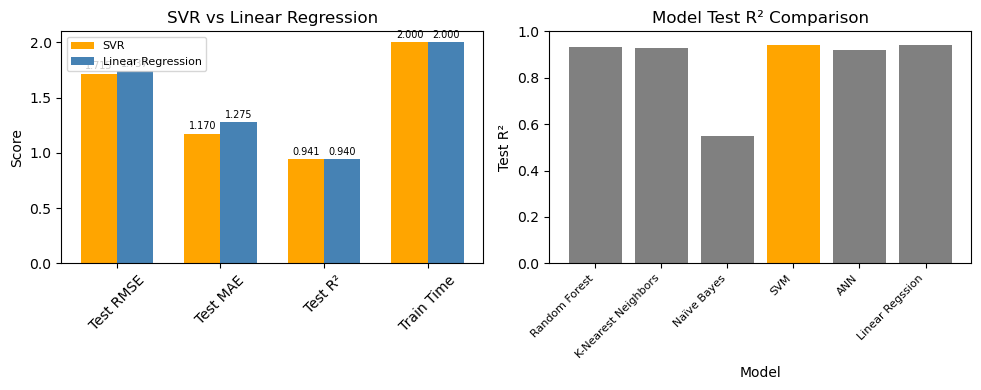

In [27]:
# -------------------------------
# Data for SVR vs Linear Regression
# -------------------------------
metrics = ['Test RMSE', 'Test MAE', 'Test R²', 'Train Time']
svm_values = [1.715, 1.170, 0.941, 2]   
lr_values = [1.737, 1.275, 0.940, 2]    
x = np.arange(len(metrics))
width = 0.35

# -------------------------------
# Data for R² comparison of all models
# -------------------------------
models = [
    "Random Forest",
    "K-Nearest Neighbors",
    "Naïve Bayes",
    "SVM",
    "ANN",
    "Linear Regssion"
]
r2_scores = [0.933, 0.929, 0.550, 0.941, 0.920, 0.940]
colors = ['gray' if model != "SVM" else 'orange' for model in models]

# -------------------------------
# Plotting both charts side by side
# -------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))  # Compact side-by-side

# Left plot: SVR vs Linear Regression
bars1 = ax1.bar(x - width/2, svm_values, width, label='SVR', color='orange')
bars2 = ax1.bar(x + width/2, lr_values, width, label='Linear Regression', color='steelblue')
ax1.set_ylabel('Score')
ax1.set_title('SVR vs Linear Regression')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45)
ax1.legend(fontsize=8)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 2),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=7)

# Right plot: R² comparison of all models
ax2.bar(models, r2_scores, color=colors)
ax2.set_title("Model Test R² Comparison")
ax2.set_xlabel("Model")
ax2.set_ylabel("Test R²")
ax2.set_ylim(0, 1)
ax2.set_xticklabels(models, rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()


## Comparative Model Analysis

### Performance Comparison

| Model                           | CV RMSE (±std) | Test RMSE | Test MAE | Test R² | Train Time  | Key Params                                           |
|---------------------------------|----------------|-----------|----------|---------|-------------|------------------------------------------------------|
| Random Forest (RF)              | 2.265 ± 0.134  | 1.838     | 1.326    | 0.933   | Fast        | `n_estimators=100`                                   |
| K‑Nearest Neighbors (KNN)       | 2.369 ± 0.097  | 1.884     | 1.359    | 0.929   | Very Fast   | `n_neighbors=3, weights='distance'`                  |
| Naïve Bayes (discretized)       | 5.327 ± 0.132  | 4.751     | 3.864    | 0.550   | Instant     | `bins=10, var_smoothing=1e-12`                       |
| SVR (RBF)                       | 1.899 ± 0.156  | 1.715     | 1.170    | 0.941   | Moderate    | `C=500, gamma='auto', ε=0.2`                         |
| ANN            | 2.225 ± 0.110  | 2.001     | 1.467    | 0.920   | Slow        | tuned hidden layers, dropout, manual LR decay            |
| Linear Reg. w/ Basis Expansion  | 2.091 ± 0.091  | 1.737     | 1.275    | 0.940   | Moderate    | `poly=3, rbf_γ=0.1, rbf_n=100, spline=3, knots=10`   |

### Key Findings

- **Top performer**: SVR achieves the best balance of low errors (RMSE 1.715, MAE 1.170) and high R² (0.941).  
- **Close contender**: Basis‑expanded Linear Regression nearly matches SVR (RMSE 1.737, R² 0.940) with interpretable coefficients.  
- **Strong baselines**: RF and KNN generalize well (R² 0.929– 0.933) with minimal feature prep.  
- **Deep model**: ANN performs solidly (R² 0.920) but at greater training cost.  
- **Poor fit**: Discretized Naïve Bayes is not suitable for regression (R² 0.550).

### Feature Importance

- **RF impurity importance**  
  1. frequency: 0.325  
  2. suction_side_thickness: 0.270  
  3. chord_length: 0.205  
  4. angle_of_attack: 0.140  
  5. free_stream_velocity: 0.060  

- **SVR single‑feature R²**  
  1. frequency: 0.181  
  2. suction_side_thickness: 0.102  
  3. chord_length: 0.027  
  4. angle_of_attack: 0.006  
  5. free_stream_velocity: –0.015  

- **Basis‑LR single‑feature R²**  
  1. frequency: 0.188  
  2. suction_side_thickness: 0.126  
  3. angle_of_attack: 0.086  
  4. chord_length: 0.055  
  5. free_stream_velocity: 0.007  

Across methods, **frequency** and **suction_side_thickness** consistently drive predictive performance.

### Model Characteristics & Trade‑offs

- **Complexity vs. Speed**: KNN & Naïve Bayes train instantly; RF/Basis‑LR moderate; ANN slowest.  
- **Interpretability**: RF & Basis‑LR offer clear importance/coefficient insights; SVR & ANN are less transparent.  
- **Non‑linear capture**: SVR, ANN, and basis expansion handle complex patterns; RF captures interactions automatically; KNN leverages local neighborhoods.  

### Recommendations

- **Maximize accuracy**: Choose **SVR** with RBF kernel.  
- **Balance speed & interpretability**: Use **Basis‑expanded Linear Regression**.  
- **Quick baseline**: Start with **Random Forest** or **KNN** for minimal preprocessing.  

---

## Conclusion

All models capture the core aerodynamic patterns, but they differ in complexity, speed, and transparency. SVR leads in accuracy, while basis‑expanded linear models and Random Forest offer strong performance with easier interpretation. KNN provides a fast, simple check and ANN confirms that deep architectures can match kernel methods at higher cost. Consistent feature analysis highlights **frequency** and **suction_side_thickness** as the most critical predictors for future modeling and experimental design.
